# 📄 Project Introduction

This project implements a lightweight and modular AI framework for the **automatic search and validation of documentary content** using a Retrieval-Augmented Generation (RAG) pipeline.

It is designed for corporate environments where policies, procedures, technical manuals, and compliance documents must be checked for the presence of **specific requirements** (e.g., ISO 27001 controls).

### ✔ Core capabilities
- **Document ingestion** from PDF, DOCX, PPTX, and TXT  
- **Semantic chunking + embeddings** using OpenAI or fully local LLMs (Ollama)  
- **Persistent vector database** (Chroma) for fast semantic retrieval  
- **RAG-based question answering**, strictly grounded in retrieved context  
- **Requirement validation module** that returns:  
  - *present / not present / uncertain*  
  - justification  
  - evidence (source chunks)  
- **Hallucination mitigation** using a secondary verification step  
- **Optional LangGraph workflow**, modeling the pipeline as nodes  
  (retrieve → generate → verify)

###  Goal
The goal is to demonstrate how modern LLMs + semantic search can **automate manual document review**, reduce human error, and provide **consistent, auditable compliance checking** in corporate settings.


# 🔧 0. Environment Setup

Before running the RAG Document Validation framework, we install the required
Python libraries.

This project uses:

### ✔ Core RAG Components
- **LangChain** (retrievers, prompt templates, chains)
- **ChromaDB** (persistent vector store)
- **Ollama** or **OpenAI** embeddings and chat models

### ✔ Workflow Orchestration (Optional)
- **LangGraph** for modeling the RAG pipeline as a graph  
  (retrieve → generate → verify)

### ✔ Utility
- **python-dotenv** for loading `.env` configuration

All dependencies are included in `requirements.txt`.  


In [1]:
# Install project requirements
!pip install -r requirements.txt

In [2]:
env_content = """
# ======================================
# LLM Provider Settings
# ======================================
LLM_PROVIDER=ollama
# Default local model (must be installed using: ollama pull llama3)
OLLAMA_MODEL=llama3

# ======================================
# Embedding Model Settings
# ======================================
# Local embeddings using Ollama
EMBED_PROVIDER=ollama
EMBED_MODEL=nomic-embed-text

# ======================================
# Vector Store Settings
# ======================================
VECTOR_DB=chroma
COLLECTION=docval

# ======================================
# API Keys (Optional)
# ======================================
# Leave these empty if using local models
OPENAI_API_KEY=
MISTRAL_API_KEY=

# Optional: Pinecone (not used by default)
PINECONE_API_KEY=
PINECONE_INDEX=docval
"""

with open(".env", "w") as f:
    f.write(env_content)

print("Created .env file successfully. Ensure that Ollama is installed locally.")


Created .env file successfully. Ensure that Ollama is installed locally.


## 1. Imports, Paths, and Environment Setup

This notebook begins by importing the core libraries used for the RAG (Retrieval-Augmented Generation) pipeline and setting up the project directory structure.

### Standard Python utilities
- `os` and `json` for file and path operations.
- `dotenv.load_dotenv` for loading configuration values (model names, provider settings) from the `.env` file.

### LangChain document loaders
These classes allow reading different document formats into a unified `Document` structure:
- `PyPDFLoader` for PDF files  
- `Docx2txtLoader` for DOCX files  
- (Optional) `UnstructuredPowerPointLoader` for PPTX files  

### Text splitting
- `RecursiveCharacterTextSplitter` is used to divide long documents into semantically coherent chunks suitable for embedding.

### Embeddings and vector store
The framework supports:
- **Ollama embeddings** (default, fully local and free)
- **OpenAI embeddings** (optional, if API key is provided)

For retrieval, the system uses:
- **Chroma**, a persistent vector database stored locally.

### Language models
The notebook loads a chat model via a helper function that can switch between:
- Ollama (default, local)
- OpenAI (optional)
- Mistral (optional)

### Directory setup
- `BASE_DIR` points to the project root.
- `DATA_DIR` contains the documents to ingest.
- `VECTOR_DIR` stores the vector database.

### Environment configuration
`load_dotenv()` loads all settings from `.env`, allowing model providers and embedding options to be selected without modifying code.


In [3]:
# Core Python utilities
import os
import json

# Environment variable loader
from dotenv import load_dotenv

# LangChain document loaders
from langchain_community.document_loaders import (
    Docx2txtLoader,
    PyPDFLoader
)

# Optional PPTX support (enable only if needed)
# from langchain_community.document_loaders import UnstructuredPowerPointLoader

# Text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Document container
from langchain_core.documents import Document

# Load environment variables from .env
load_dotenv()

# Project directories
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
VECTOR_DIR = os.path.join(BASE_DIR, "vector")

print("Environment loaded.")
print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("VECTOR_DIR:", VECTOR_DIR)


Environment loaded.
BASE_DIR: /Users/mona/test project of rag
DATA_DIR: /Users/mona/test project of rag/data
VECTOR_DIR: /Users/mona/test project of rag/vector


## 2. LLM Selection (`get_chat_model`)

This helper function selects the large language model (LLM) backend based on
settings stored in the `.env` file. The rest of the notebook simply calls
`get_chat_model()` without worrying about which provider is used underneath.

### Supported providers
- **Ollama** (`LLM_PROVIDER=ollama`)  
  Default choice. Runs fully locally and does not require API keys.

- **OpenAI** (`LLM_PROVIDER=openai`)  
  Optional. Used only if an API key is provided.

- **Mistral** (`LLM_PROVIDER=mistral`)  
  Optional. Requires an API key.

### Environment variables controlling the behavior
- `LLM_PROVIDER`  
  Determines which backend to use: `ollama`, `openai`, or `mistral`.

- `OLLAMA_MODEL`  
  Model name for Ollama (e.g. `llama3.1`).

- `CHAT_MODEL`  
  OpenAI model name (e.g. `gpt-4o-mini`). Only used if provider is OpenAI.

- `MISTRAL_MODEL`  
  Model name for the Mistral API.

The goal is to keep the RAG pipeline provider-agnostic: the same codebase can
run entirely locally (Ollama) or switch to hosted LLM services simply by
changing `.env` variables.


In [4]:
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain_community.chat_models import ChatOllama
import os

def get_chat_model():
    """
    Selects the chat model backend based on environment variables.
    Supports: Ollama (default), OpenAI, Mistral.
    """
    provider = os.getenv("LLM_PROVIDER", "ollama").lower()

    # -------- OpenAI backend --------
    if provider == "openai":
        api_key = os.getenv("OPENAI_API_KEY", "").strip()
        if not api_key:
            raise ValueError("OPENAI_API_KEY is not set. Provide a key or switch provider to 'ollama'.")
        model = os.getenv("CHAT_MODEL", "gpt-4o-mini")
        return ChatOpenAI(model=model, temperature=0)

    # -------- Mistral backend --------
    if provider == "mistral":
        api_key = os.getenv("MISTRAL_API_KEY", "").strip()
        if not api_key:
            raise ValueError("MISTRAL_API_KEY is not set. Provide a key or switch provider to 'ollama'.")
        model = os.getenv("MISTRAL_MODEL", "mistral-large-latest")
        return ChatMistralAI(model=model, temperature=0)

    # -------- Ollama backend (default, local, free) --------
    if provider == "ollama":
        model = os.getenv("OLLAMA_MODEL", "llama3.1")
        return ChatOllama(model=model, temperature=0)

    # -------- Fallback --------
    return ChatOllama(model="llama3.1", temperature=0)


In [5]:
llm = get_chat_model()
llm


/var/folders/36/5wb7gt6s3h92jhx7fj1lm3hm0000gn/T/ipykernel_47656/3468636113.py:32: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  return ChatOllama(model=model, temperature=0)


ChatOllama(model='llama3', temperature=0.0)

## 3. Vector Store Selection (`get_retriever`)

This function selects the vector database backend used for semantic retrieval.
In this notebook, the default and fully implemented backend is **Chroma**, a
local on-disk persistent vector store.

The retriever returned by this function is used to:
1. Encode incoming queries into embeddings.
2. Perform similarity search or Max Marginal Relevance (MMR) search.
3. Return the most relevant document chunks to the RAG pipeline.

### Supported backend in this implementation
- **Chroma** (`VECTOR_DB=chroma`)  
  Persistent local vector store. Fast, reliable, and ideal for a lightweight
  document validation framework.

### Optional / not enabled by default
The framework is structured so that FAISS and Pinecone could be added, but they
are not active in this notebook:
- `faiss` – in-memory local index  
- `pinecone` – managed cloud vector database  

Only Chroma is used for ingestion, retrieval, and validation.

### Behavior
`get_retriever()`:
1. Loads the embedding model according to `.env` settings  
   (Ollama embeddings by default, OpenAI if configured).  
2. Opens the Chroma collection stored in `VECTOR_DIR`.  
3. Wraps it as a retriever that supports `.invoke(query)` to obtain relevant
   chunks.

This design allows the rest of the system to remain backend-agnostic.


In [6]:
# Embeddings
from langchain_community.embeddings import OllamaEmbeddings

# Vector store (Chroma only, since this notebook uses Chroma for retrieval)
from langchain_chroma import Chroma


In [7]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_chroma import Chroma
import os

def get_embeddings():
    """
    Select the embedding model backend.
    Default: local Ollama embeddings (free).
    Optional: OpenAI embeddings if configured in .env.
    """
    provider = os.getenv("EMBED_PROVIDER", "ollama").lower()
    model = os.getenv("EMBED_MODEL", "nomic-embed-text")

    print(f"[Embedding] Provider: {provider}")
    print(f"[Embedding] Model: {model}")

    # Local free embeddings
    if provider == "ollama":
        return OllamaEmbeddings(model=model)

    # Optional: OpenAI embeddings
    from langchain_openai import OpenAIEmbeddings
    return OpenAIEmbeddings(model=model)


def get_retriever():
    """
    Initialize the vector database (Chroma) and return a retriever.
    This implementation focuses on Chroma as the persistent local store.
    """
    print("======================================")
    print("      INITIALIZING RETRIEVER")
    print("======================================")

    embeddings = get_embeddings()  # also prints debug info

    persist_dir = os.path.join(VECTOR_DIR, "chroma")
    os.makedirs(persist_dir, exist_ok=True)

    print(f"[Chroma] Persist directory: {persist_dir}")
    print("[Chroma] Loading or creating Chroma DB...")

    vectordb = Chroma(
        collection_name=os.getenv("COLLECTION", "docval"),
        embedding_function=embeddings,
        persist_directory=persist_dir,
    )

    print("[Chroma] Vector DB ready.")
    print("[Chroma] Returning MMR retriever.\n")

    return vectordb.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 8, "fetch_k": 32, "lambda_mult": 0.5},
    )


In [8]:
print("---- TESTING EMBEDDINGS ----")
emb = get_embeddings()
print("Embedding object:", emb)

print("\n---- TESTING RETRIEVER ----")
retriever = get_retriever()
print("Retriever object:", retriever)


---- TESTING EMBEDDINGS ----
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
Embedding object: base_url='http://localhost:11434' model='nomic-embed-text' embed_instruction='passage: ' query_instruction='query: ' mirostat=None mirostat_eta=None mirostat_tau=None num_ctx=None num_gpu=None num_thread=None repeat_last_n=None repeat_penalty=None temperature=None stop=None tfs_z=None top_k=None top_p=None show_progress=False headers=None model_kwargs=None

---- TESTING RETRIEVER ----
      INITIALIZING RETRIEVER
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
[Chroma] Persist directory: /Users/mona/test project of rag/vector/chroma
[Chroma] Loading or creating Chroma DB...
[Chroma] Vector DB ready.
[Chroma] Returning MMR retriever.

Retriever object: tags=['Chroma', 'OllamaEmbeddings'] vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x113230440> search_type='mmr' search_kwargs={'k': 8, 'fetch_k': 32, 'lambda_mult': 0.5}


/var/folders/36/5wb7gt6s3h92jhx7fj1lm3hm0000gn/T/ipykernel_47656/1764496543.py:19: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  return OllamaEmbeddings(model=model)


## 4. File Loading and Text Chunking Helpers

This section defines the utility functions used to load documents from disk and
convert them into text chunks suitable for embedding and retrieval.

### `_file_type(path)`
Identifies the file type from the extension and returns a simple label:
- `.docx` → `docx`
- `.pdf` → `pdf`
- `.pptx` → `pptx`
- anything else → `other` (ignored)

### `_load_text(abs_path, ftype)`
Loads the raw text from a document according to its type:
- `docx`: extracted using `Docx2txtLoader`
- `pdf`: loaded page-by-page using `PyPDFLoader`, then pages concatenated
- `pptx`: (optional) loaded using `UnstructuredPowerPointLoader`
- unsupported types are skipped

This function always returns a single text string representing the full document.

### `_chunk_text(text)`
Splits long text into overlapping chunks using `RecursiveCharacterTextSplitter`
with:
- `chunk_size = 1000` characters  
- `chunk_overlap = 200` characters  

This produces a list of LangChain `Document` objects, each containing a text
chunk and associated metadata.

The purpose of these helpers is to standardize preprocessing so that all
documents, regardless of file type, follow a consistent pipeline before being
embedded and indexed in the vector store.


In [9]:
def _file_type(path: str) -> str:
    ext = os.path.splitext(path)[1].lower()
    if ext == ".docx":
        return "docx"
    if ext == ".pdf":
        return "pdf"
    if ext == ".pptx":
        return "pptx"
    return "other"


def _load_text(abs_path: str, ftype: str) -> str:
    if ftype == "docx":
        docs = Docx2txtLoader(abs_path).load()
        return docs[0].page_content
    if ftype == "pdf":
        docs = PyPDFLoader(abs_path).load()
        return "\n\n".join(d.page_content for d in docs)
    if ftype == "pptx":
        slides = UnstructuredPowerPointLoader(abs_path).load()
        return "\n\n".join(d.page_content or "" for d in slides)
    raise ValueError(f"Unsupported file type: {ftype}")


def _chunk_text(text: str):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        separators=["\n\n", "\n", ". ", " "],
    )
    return splitter.split_documents([Document(page_content=text)])

print("✔ File helper functions LOADED.")



✔ File helper functions LOADED.


## 5. Ingestion Pipeline (`ingest`)

The `ingest()` function processes all documents in the `data/` directory and
prepares them for retrieval. It performs three main tasks:

1. **Load raw documents**  
   The function scans the `data/` folder recursively.  
   For each supported file (`.pdf`, `.docx`, optional `.pptx`):
   - determine its type using `_file_type()`
   - load the full text using `_load_text()`
   - split the text into chunks using `_chunk_text()`

2. **Add metadata**  
   Each chunk is wrapped in a `Document` object with metadata including:
   - source file path  
   - file name  
   - file type  
   - ingestion timestamp  

3. **Store embeddings in a vector database**  
   The system uses **ChromaDB** as the persistent local vector store.  
   Steps:
   - initialize the embedding model (`get_embeddings()`)
   - open or create the Chroma collection in `VECTOR_DIR`
   - insert all chunks with their embeddings

At the end of the process, the vector database contains semantically searchable
representations of all documents. This database is later used by the retriever
for RAG-based question answering and requirement validation.


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from datetime import datetime
from datetime import datetime, timezone

def ingest():
    """
    Load all documents from DATA_DIR, chunk them, and store them in Chroma.
    This is the only backend supported in this notebook.
    """
    print("======================================")
    print("            INGEST START")
    print("======================================")

    os.makedirs(DATA_DIR, exist_ok=True)

    embeddings = get_embeddings()
    all_docs = []

    print(f"[Ingest] Scanning folder: {DATA_DIR}")

    # -----------------------------------------------------
    # Load all supported files in DATA_DIR
    # -----------------------------------------------------
    for root, _, files in os.walk(DATA_DIR):
        if ".ipynb_checkpoints" in root:
            continue

        for name in files:
            if name.startswith("~$"):
                continue

            ftype = _file_type(name)
            if ftype == "other":
                continue

            path = os.path.join(root, name)
            print(f"[Load] {path} (type={ftype})")

            text = _load_text(path, ftype)
            if not text.strip():
                print(f"[Skip] Empty file: {name}")
                continue

            chunks = _chunk_text(text)
            print(f"[Chunks] {len(chunks)} chunks created.")

            ts = datetime.now(timezone.utc).isoformat()


            for chunk in chunks:
                all_docs.append(
                    Document(
                        page_content=chunk.page_content,
                        metadata={
                            "source_path": path.replace("\\", "/"),
                            "filename": name,
                            "type": ftype,
                            "ingested_at": ts,
                        },
                    )
                )

    if not all_docs:
        print("[Ingest] No supported documents found.")
        print("======================================")
        print("            INGEST END")
        print("======================================")
        return {"backend": "chroma", "count": 0}

    print(f"[Ingest] Total chunks to index: {len(all_docs)}")

    # -----------------------------------------------------
    # Store in Chroma
    # -----------------------------------------------------
    persist_dir = os.path.join(VECTOR_DIR, "chroma")
    os.makedirs(persist_dir, exist_ok=True)

    print(f"[Chroma] Persist directory: {persist_dir}")

    vectordb = Chroma(
        collection_name=os.getenv("COLLECTION", "docval"),
        embedding_function=embeddings,
        persist_directory=persist_dir,
    )

    vectordb.add_documents(all_docs)
    print("[Chroma] Documents added to vector store.")

    print("======================================")
    print("             INGEST END")
    print("======================================")

    return {"backend": "chroma", "count": len(all_docs)}


In [12]:
result = ingest()
result


            INGEST START
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
[Ingest] Scanning folder: /Users/mona/test project of rag/data
[Load] /Users/mona/test project of rag/data/ACME_Information_Security_Policy.pdf (type=pdf)


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 31 0 (offset 0)


[Chunks] 12 chunks created.
[Ingest] Total chunks to index: 12
[Chroma] Persist directory: /Users/mona/test project of rag/vector/chroma
[Chroma] Documents added to vector store.
             INGEST END


{'backend': 'chroma', 'count': 12}

## 6. RAG Chat Function (`chat`)

This section implements the main question-answering function using a
Retrieval-Augmented Generation (RAG) pipeline.

### `_concat(docs)`
Helper function that joins the `page_content` of retrieved documents into a
single context string.

### `chat(question)`
This function executes a full RAG pass:

1. Initialize the retriever and language model.
2. Retrieve the most relevant document chunks for the question.
3. Concatenate the chunks into a contextual text block.
4. Build a prompt instructing the model to:
   - answer strictly using the provided context  
   - admit "I don't know" when the context does not contain the answer
5. Run the LLM on the question + context.
6. Return a dictionary containing:
   - `answer`: model output  
   - `context`: text actually used for grounding  
   - `docs`: list of retrieved chunks and their metadata  

This is the core RAG function used throughout the notebook to query the indexed documents.


In [24]:
from langchain_core.prompts import ChatPromptTemplate

def _concat(docs):
    if not docs:
        return ""
    return "\n\n".join(d.page_content for d in docs)


def chat(question: str):
    print("\n======================================")
    print("               CHAT START")
    print("======================================")

    retriever = get_retriever()
    llm = get_chat_model()

    print("[Chat] Retrieving documents...")
    docs = retriever.invoke(question)   # modern LangChain API
    print(f"[Chat] Retrieved {len(docs)} docs.")

    # If nothing retrieved → return safe “I don’t know”
    if not docs:
        print("[Chat] No documents retrieved. Returning fallback answer.")
        return {
            "answer": "I don't know. No relevant content was found in the indexed documents.",
            "context": "",
            "docs": [],
        }

    context = _concat(docs)

    # Build clean prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                (
                    "You are a strict document assistant. "
                    "Answer ONLY using the provided context. "
                    "If the answer is not contained in the context, respond with: I don't know."
                )
            ),
            ("system", "Context:\n{context}"),
            ("human", "{question}"),
        ]
    )

    chain = prompt | llm

    print("[Chat] Calling LLM...")
    response = chain.invoke(
        {
            "context": context,
            "question": question,
        }
    )

    answer_text = response.content
    print("[Chat] DONE.")
    print("======================================")

    return {
    "answer": answer_text,
    "context": context,
    "docs": [
        {
            "source_path": d.metadata.get("source_path"),
            "filename": d.metadata.get("filename"),
        }
        for d in docs
    ],
}


In [26]:
# Example RAG Query
question = "What policies does the document define?"
resp = chat(question)

print("\n===================== ANSWER =====================")
print(resp["answer"])

print("\n===================== UNIQUE SOURCE FILES =====================")

# Build a summary of unique files and how many chunks came from each
unique_sources = {}

for d in resp["docs"]:
    fname = d["filename"]
    if fname not in unique_sources:
        unique_sources[fname] = {
            "source_path": d.get("source_path", ""),
            "type": d.get("type", ""),
            "ingested_at": d.get("ingested_at", ""),
            "chunks_retrieved": 0
        }
    unique_sources[fname]["chunks_retrieved"] += 1

# Display clean summary
for fname, meta in unique_sources.items():
    print(f"- {fname}")
    print(f"    path: {meta['source_path']}")
    print(f"    type: {meta['type']}")
    print(f"    ingested_at: {meta['ingested_at']}")
    print(f"    chunks_retrieved: {meta['chunks_retrieved']}")



               CHAT START
      INITIALIZING RETRIEVER
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
[Chroma] Persist directory: /Users/mona/test project of rag/vector/chroma
[Chroma] Loading or creating Chroma DB...
[Chroma] Vector DB ready.
[Chroma] Returning MMR retriever.

[Chat] Retrieving documents...
[Chat] Retrieved 8 docs.
[Chat] Calling LLM...
[Chat] DONE.

===================== ANSWER =====================
The document defines one information security policy: "ACME CORPORATION – INFORMATION SECURITY POLICY".

===================== UNIQUE SOURCE FILES =====================
- ACME_Information_Security_Policy.pdf
    path: /Users/mona/test project of rag/data/ACME_Information_Security_Policy.pdf
    type: 
    ingested_at: 
    chunks_retrieved: 8


# LangGraph RAG Pipeline

This section demonstrates how the RAG workflow can be modeled as an explicit
graph using LangGraph. Instead of running retrieval and generation as a single
linear function call, LangGraph allows us to define a pipeline with named nodes
and explicit transitions.

This improves:
- transparency of the RAG workflow  
- debuggability (each node can be inspected independently)  
- extensibility (additional nodes such as verification, re-ranking, etc.)

### Pipeline Nodes

1. **retrieve**  
   Uses the retriever to fetch the most relevant document chunks for the
   question. The output contains:
   - retrieved documents
   - the concatenated context string

2. **generate**  
   Calls the LLM to produce an answer using only the retrieved context. The
   answer is stored in the graph state.

The graph is then compiled into an executable `app_rag` pipeline that can be
invoked with a question. LangGraph automatically manages state propagation
between nodes.


In [27]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document

# -----------------------------
# 1. Define pipeline state
# -----------------------------
class RagState(TypedDict):
    question: str
    context: str
    answer: str
    docs: List[Document]


# -----------------------------
# 2. Define retrieve node
# -----------------------------
def retrieve(state: RagState):
    print("--- RETRIEVE ---")

    question = state["question"]
    retriever = get_retriever()

    docs = retriever.invoke(question)
    print(f"[Retrieve] Retrieved {len(docs)} docs.")

    if not docs:
        return {
            "docs": [],
            "context": "",
        }

    context = _concat(docs)

    return {
        "docs": docs,
        "context": context,
    }


# -----------------------------
# 3. Define generate node
# -----------------------------
def generate(state: RagState):
    print("--- GENERATE ---")

    question = state["question"]
    context = state.get("context", "")
    llm = get_chat_model()

    if not context.strip():
        return {
            "answer": "I don't know. No relevant information was retrieved."
        }

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a strict document assistant. "
            "Answer ONLY using the given context. "
            "If the answer is not present, say: I don't know."
        ),
        ("system", "Context:\n{context}"),
        ("human", "{question}")
    ])

    chain = prompt | llm
    resp = chain.invoke({"context": context, "question": question})

    return {"answer": resp.content}


# -----------------------------
# 4. Build the graph
# -----------------------------
workflow = StateGraph(RagState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

app_rag = workflow.compile()


# -----------------------------
# 5. Demo run
# -----------------------------
print("--- RUNNING LANGGRAPH RAG ---")
inputs = {"question": "What is the CISO responsible for?"}
result = app_rag.invoke(inputs)
print("\nLangGraph Answer:", result["answer"])


--- RUNNING LANGGRAPH RAG ---
--- RETRIEVE ---
      INITIALIZING RETRIEVER
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
[Chroma] Persist directory: /Users/mona/test project of rag/vector/chroma
[Chroma] Loading or creating Chroma DB...
[Chroma] Vector DB ready.
[Chroma] Returning MMR retriever.

[Retrieve] Retrieved 8 docs.
--- GENERATE ---

LangGraph Answer: According to the provided context, the CISO (Chief Information Security Officer) is responsible for:

* Owning and maintaining this policy
* Approving security standards and procedures
* Coordinating incident response actions


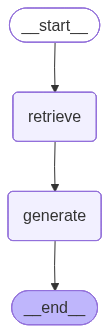

In [17]:
from IPython.display import Image, display

display(Image(app_rag.get_graph().draw_mermaid_png()))


In [18]:
print(app_rag.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	retrieve(retrieve)
	generate(generate)
	__end__([<p>__end__</p>]):::last
	__start__ --> retrieve;
	retrieve --> generate;
	generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



## 7. Answer Verification (`verify`)

This function evaluates whether the generated answer is actually supported by the
retrieved context. The goal is to detect hallucinations and assign a confidence
score to the answer.

### Verification steps
1. Build a prompt containing:
   - the original question
   - the generated answer
   - the retrieved context

2. Ask the model to classify the answer as one of:
   - `supported` — fully grounded in the context  
   - `partially_supported` — context contains related information but does not fully justify the answer  
   - `unsupported` — answer does not follow from the context  

3. Convert the classification into a numerical confidence score:
   - `supported` → **1.0**  
   - `partially_supported` → **0.5**  
   - `unsupported` → **0.0**  

This provides a lightweight hallucination-detection method that estimates the
reliability of the answer derived through the RAG pipeline.


In [28]:
from langchain_core.prompts import ChatPromptTemplate

def verify(question: str, answer: str, context: str):
    print("\n======================================")
    print("             VERIFY START")
    print("======================================")

    llm = get_chat_model()

    vprompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                (
                    "You are a strict answer verifier. Determine whether the ANSWER "
                    "is supported by the CONTEXT. You MUST return exactly one of:\n"
                    "- supported\n"
                    "- partially_supported\n"
                    "- unsupported\n"
                    "Do NOT explain. Do NOT add anything else."
                )
            ),
            (
                "human",
                "QUESTION:\n{q}\n\nANSWER:\n{a}\n\nCONTEXT:\n{c}\n\nReturn ONLY the label:"
            ),
        ]
    )

    chain = vprompt | llm

    print("[Verify] Calling verifier model...")
    raw_output = chain.invoke(
        {"q": question, "a": answer, "c": context}
    ).content.strip().lower()

    print(f"[Verify] Raw model output: '{raw_output}'")

    # ---------- Normalization ----------
    verdict = "unsupported"  # safe default

    if raw_output.startswith("supported") and not raw_output.startswith("partially"):
        verdict = "supported"
    elif raw_output.startswith("partially"):
        verdict = "partially_supported"

    # ---------- Confidence scoring ----------
    confidence_map = {
        "supported": 1.0,
        "partially_supported": 0.5,
        "unsupported": 0.0,
    }
    confidence = confidence_map[verdict]

    print(f"[Verify] Verdict: {verdict}")
    print(f"[Verify] Confidence: {confidence}")
    print("======================================")

    return {
        "verdict": verdict,
        "confidence": confidence,
        "raw_model_output": raw_output,
    }


In [29]:
resp = chat("Does the policy include incident response?")
answer = resp["answer"]
context = resp["context"]

verify("Does the policy include incident response?", answer, context)



               CHAT START
      INITIALIZING RETRIEVER
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
[Chroma] Persist directory: /Users/mona/test project of rag/vector/chroma
[Chroma] Loading or creating Chroma DB...
[Chroma] Vector DB ready.
[Chroma] Returning MMR retriever.

[Chat] Retrieving documents...
[Chat] Retrieved 8 docs.
[Chat] Calling LLM...
[Chat] DONE.

             VERIFY START
[Verify] Calling verifier model...
[Verify] Raw model output: 'supported'
[Verify] Verdict: supported
[Verify] Confidence: 1.0


{'verdict': 'supported', 'confidence': 1.0, 'raw_model_output': 'supported'}

## 8. Requirement Validation (`validate`)

This function implements the core compliance-checking capability of the framework.
Given a list of requirement statements (e.g., ISO 27001 controls), the function
automatically determines whether each requirement is present in the document.

### Validation steps

For every requirement:

1. **Retrieve relevant chunks**  
   Use the retriever to fetch the most semantically similar document fragments.

2. **Assemble context**  
   Combine the retrieved chunks into a concise context string.

3. **Ask the LLM to decide**  
   Prompt the model with the requirement and the context, instructing it to answer:
   - `"yes"` if the requirement is clearly supported
   - `"no"` otherwise  
   The model must also provide a short justification.

4. **Interpret the response**  
   - If the answer begins with `"yes"` → `present = True`  
   - Otherwise → `present = False`  

5. **Return structured results**  
   Each requirement returns:
   - `requirement` — the original text  
   - `present` — boolean indicating whether it is found  
   - `raw` — the full LLM justification  
   - `docs` — metadata for retrieved supporting chunks  

### Purpose

This provides an automated way to validate whether a policy, specification, or
technical document contains the required content. It directly supports the thesis
goal of automatic document compliance checking.


In [30]:
from langchain_core.prompts import ChatPromptTemplate

def validate(requirements):
    print("\n======================================")
    print("           VALIDATION START")
    print("======================================")

    retriever = get_retriever()
    llm = get_chat_model()

    vprompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                (
                    "You are a strict compliance validator. Determine whether the "
                    "REQUIREMENT is present in the document based ONLY on the CONTEXT.\n\n"
                    "Return exactly one of the following formats:\n"
                    "  yes: <short justification>\n"
                    "  no: <short justification>\n\n"
                    "No extra sentences. No explanations beyond the short justification."
                )
            ),
            (
                "human",
                "Requirement:\n{req}\n\nContext:\n{ctx}\n\nReturn your decision:"
            ),
        ]
    )

    chain = vprompt | llm
    results = []

    for req in requirements:
        print("\n--------------------------------------")
        print(f"[Validate] Requirement: {req}")

        # modern API: retriever.invoke()
        docs = retriever.invoke(req)
        print(f"[Validate] Retrieved {len(docs)} docs")

        if not docs:
            print("[Validate] No context → auto 'no'")
            results.append({
                "requirement": req,
                "present": False,
                "raw": "no: no supporting context found",
                "confidence": 0.0,
                "docs": [],
            })
            continue

        ctx = _concat(docs)

        # Call model
        resp = chain.invoke({"req": req, "ctx": ctx}).content.strip()
        raw = resp.lower()

        print(f"[Validate] Raw LLM output: {resp}")

        # ---------- normalize yes/no ----------
        if raw.startswith("yes"):
            present = True
            confidence = 1.0
        elif raw.startswith("no"):
            present = False
            confidence = 0.0
        else:
            # safety fallback
            present = False
            confidence = 0.0
            resp = "no: unclear model output"

        print(f"[Validate] Present? {present}")

        # metadata
        doc_meta = [
            {
                "source_path": d.metadata.get("source_path"),
                "filename": d.metadata.get("filename"),
                "ingested_at": d.metadata.get("ingested_at"),
                "type": d.metadata.get("type"),
            }
            for d in docs
        ]

        results.append(
            {
                "requirement": req,
                "present": present,
                "raw": resp,
                "confidence": confidence,
                "docs": doc_meta,
            }
        )

    print("\n======================================")
    print("           VALIDATION END")
    print("======================================")

    return results


In [31]:
reqs = [
    "The policy must include an incident response process.",
    "The policy must define roles and responsibilities.",
    "The policy must describe backup and recovery.",
    "The policy must define VPN usage rules.",
]

results = validate(reqs)

for r in results:
    print("\nREQ:", r["requirement"])
    print("PRESENT:", r["present"])
    print("RAW:", r["raw"])
    print("FILES:", {d["filename"] for d in r["docs"]})



           VALIDATION START
      INITIALIZING RETRIEVER
[Embedding] Provider: ollama
[Embedding] Model: nomic-embed-text
[Chroma] Persist directory: /Users/mona/test project of rag/vector/chroma
[Chroma] Loading or creating Chroma DB...
[Chroma] Vector DB ready.
[Chroma] Returning MMR retriever.


--------------------------------------
[Validate] Requirement: The policy must include an incident response process.
[Validate] Retrieved 8 docs
[Validate] Raw LLM output: yes: The policy includes an incident response process, which is outlined in section 8.3 Incident Response Process.
[Validate] Present? True

--------------------------------------
[Validate] Requirement: The policy must define roles and responsibilities.
[Validate] Retrieved 8 docs
[Validate] Raw LLM output: yes: The requirement is present in section 1. Purpose, which states "to define the principles, responsibilities, and controls required to protect ACME Corporation's information assets..."
[Validate] Present? True

---